# Project 1 - Regression
## Predict total bikes that will be rented per day
### This notebook uses the *bike_day_v2.xlsx* 
### *Group J*

Diana Rodrigues 20240110

Laura Tomás 20240116

Matilde Ferreira da Costa 20240115

## Dataset description

- **instant**: record index
- **dteday** : date
- **season** : season (1:springer, 2:summer, 3:fall, 4:winter)
- **yr** : year (0: 2011, 1:2012)
- **mnth** : month ( 1 to 12)
- **holiday** : weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday** : day of the week
- **workingday** : if day is neither weekend nor holiday is 1, otherwise is 0
- **schoolday** : if day is a normal school day is 1, otherwise is 0
- **weathersit** : 
	- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- **temp** : Normalized temperature in Celsius. The values are divided to 41 (max)
- **atemp**: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- **hum**: Normalized humidity. The values are divided to 100 (max)
- **windspeed**: Normalized wind speed. The values are divided to 67 (max)
- **casual**: count of casual users
- **registered**: count of registered users
- **cnt**: count of total rental bikes including both casual and registered

## Initializations and data loading

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as  sns
import pandas as pd
import category_encoders as ce
import graphviz
import datetime

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from yellowbrick.model_selection import RFECV
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# To display plots inside the notebook
%matplotlib inline

## Data understanding

In [2]:
# Loading the dataset and visualizing summary statistics
ds = pd.read_excel('bike_day_v2.xlsx', engine='openpyxl')


In [3]:
ds.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,schoolday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6.0,0,0.0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0.0,0,0.0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1.0,1,1.0,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2.0,1,1.0,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3.0,1,1.0,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
ds.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
instant,732.0,366.352459,1.0,183.75,366.5,549.25,731.0,211.236679
dteday,732,2012-01-01 08:27:32.459016448,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-01 12:00:00,2012-07-02 06:00:00,2012-12-31 00:00:00,NaN
season,732.0,2.497268,1.0,2.0,3.0,3.0,4.0,1.110203
yr,732.0,0.501366,0.0,0.0,1.0,1.0,1.0,0.50034
mnth,732.0,6.523224,1.0,4.0,7.0,10.0,12.0,3.450769
holiday,732.0,0.028689,0.0,0.0,0.0,0.0,1.0,0.167044
weekday,730.0,3.00274,0.0,1.0,3.0,5.0,6.0,2.004793
workingday,732.0,0.68306,0.0,0.0,1.0,1.0,1.0,0.465602
schoolday,454.0,0.460352,0.0,0.0,0.0,1.0,1.0,0.498975
weathersit,732.0,1.394809,1.0,1.0,1.0,2.0,3.0,0.544718


In [5]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     732 non-null    int64         
 1   dteday      732 non-null    datetime64[ns]
 2   season      732 non-null    int64         
 3   yr          732 non-null    int64         
 4   mnth        732 non-null    int64         
 5   holiday     732 non-null    int64         
 6   weekday     730 non-null    float64       
 7   workingday  732 non-null    int64         
 8   schoolday   454 non-null    float64       
 9   weathersit  732 non-null    int64         
 10  temp        732 non-null    float64       
 11  atemp       732 non-null    float64       
 12  hum         732 non-null    float64       
 13  windspeed   732 non-null    float64       
 14  casual      732 non-null    int64         
 15  registered  732 non-null    int64         
 16  cnt         732 non-null  

`Season`, `yr`, `mnth`, `holiday`, `weekday`, `workingday`, `schoolday`, `weathersit` were identified as numeric columns, but they are categorical, so we changed the data type.

In [6]:
ds[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'schoolday', 'weathersit']] = \
    ds[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'schoolday', 'weathersit']].astype('category')

In [7]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     732 non-null    int64         
 1   dteday      732 non-null    datetime64[ns]
 2   season      732 non-null    category      
 3   yr          732 non-null    category      
 4   mnth        732 non-null    category      
 5   holiday     732 non-null    category      
 6   weekday     730 non-null    category      
 7   workingday  732 non-null    category      
 8   schoolday   454 non-null    category      
 9   weathersit  732 non-null    category      
 10  temp        732 non-null    float64       
 11  atemp       732 non-null    float64       
 12  hum         732 non-null    float64       
 13  windspeed   732 non-null    float64       
 14  casual      732 non-null    int64         
 15  registered  732 non-null    int64         
 16  cnt         732 non-null  

In [8]:
ds.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
instant,732.0,NaN,NaN,NaN,366.352459,1.0,183.75,366.5,549.25,731.0,211.236679
dteday,732,NaN,NaN,NaN,2012-01-01 08:27:32.459016448,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-01 12:00:00,2012-07-02 06:00:00,2012-12-31 00:00:00,NaN
season,732.0,4.0,3.0,189.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr,732.0,2.0,1.0,367.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mnth,732.0,12.0,1.0,62.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,732.0,2.0,0.0,711.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,730.0,7.0,6.0,106.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,732.0,2.0,1.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
schoolday,454.0,2.0,0.0,245.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weathersit,732.0,3.0,1.0,464.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Note: `weathersit` has 4 categories but only 3 were found.

Checking for highly correlated binary variables:

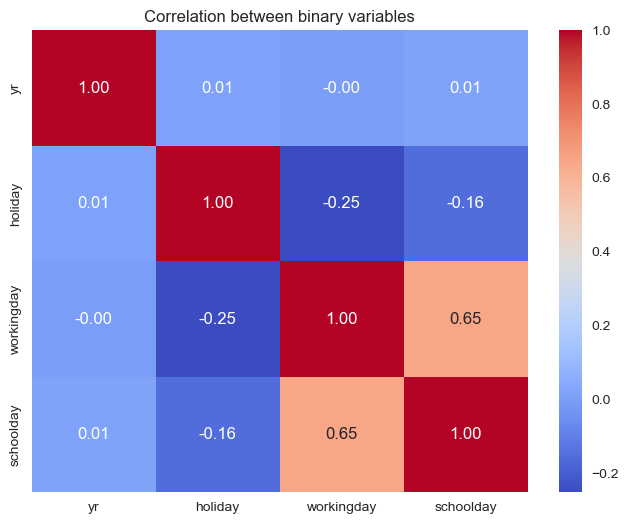

In [9]:
binary_cols = [col for col in ds.columns if ds[col].dropna().isin([0,1]).all()]
df_bin = ds[binary_cols]

correlation_matrix = df_bin.corr()
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between binary variables")
plt.show()


In [10]:
print(ds.isnull().sum())

instant         0
dteday          0
season          0
yr              0
mnth            0
holiday         0
weekday         2
workingday      0
schoolday     278
weathersit      0
temp            0
atemp           0
hum             0
windspeed       0
casual          0
registered      0
cnt             0
dtype: int64


In [11]:
ds = ds.dropna(subset=['weekday'])

In [12]:
print(ds.isnull().sum())

instant         0
dteday          0
season          0
yr              0
mnth            0
holiday         0
weekday         0
workingday      0
schoolday     278
weathersit      0
temp            0
atemp           0
hum             0
windspeed       0
casual          0
registered      0
cnt             0
dtype: int64


 Having higly correlated varibles could affect the models performance. For that reason, we choose to not use `schoolday`, so there is no need to treat this variable.
 For `weekday` there is not a lot of missing values so we decided to just delete them.

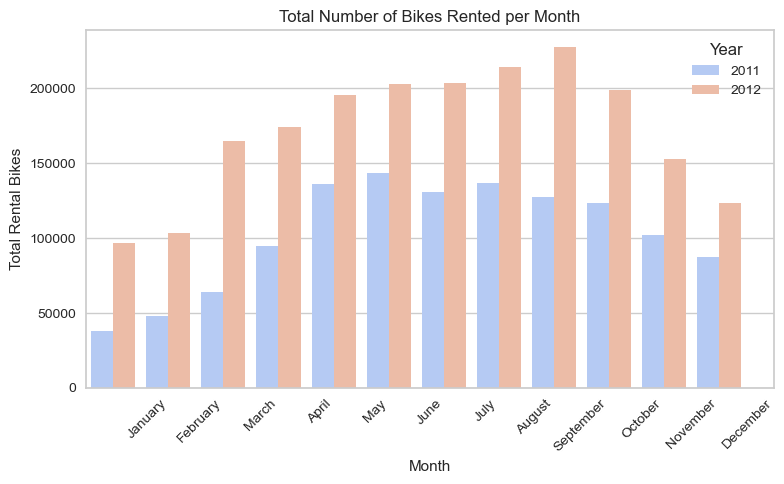

In [13]:
month_labels = {1: "January", 2: "February", 3: "March", 4: "April", 
                5: "May", 6: "June", 7: "July", 8: "August", 
                9: "September", 10: "October", 11: "November", 12: "December"}

ds["mnth"] = ds["mnth"].astype(int)

month_counts = ds.groupby(["mnth", "yr"], observed=False)["cnt"].sum().reset_index()

month_counts["mnth"] = month_counts["mnth"].astype(int)

month_counts["yr"] = month_counts["yr"].map({0: 2011, 1: 2012})

plt.figure(figsize=(8, 5))
sns.barplot(x="mnth", y="cnt", hue="yr", data=month_counts, palette="coolwarm")

plt.xticks(ticks=sorted(month_counts["mnth"].unique()), 
           labels=[month_labels[m] for m in sorted(month_counts["mnth"].unique())], rotation=45, ha='right')

plt.title("Total Number of Bikes Rented per Month")
plt.xlabel("Month")
plt.ylabel("Total Rental Bikes")
plt.legend(title="Year")

plt.tight_layout()  
plt.show()


In the previous bar plot we observed that spring and summer months are the ones when bicycles were most rented.

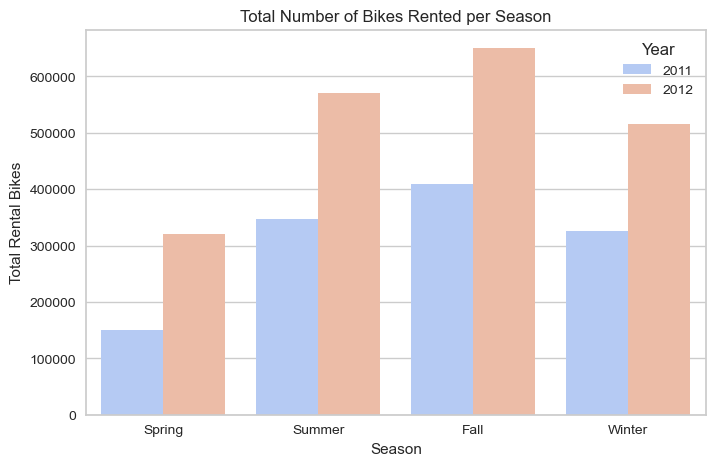

In [14]:
season_labels = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}

season_counts = ds.groupby(["season", "yr"], observed=False)["cnt"].sum().reset_index()

season_counts["season"] = season_counts["season"].map(season_labels)

season_counts["yr"] = season_counts["yr"].map({0: 2011, 1: 2012})

plt.figure(figsize=(8, 5))
sns.barplot(x="season", y="cnt", hue="yr", data=season_counts, palette="coolwarm")

plt.title("Total Number of Bikes Rented per Season")
plt.xlabel("Season")
plt.ylabel("Total Rental Bikes")
plt.legend(title="Year")

plt.show()

After generating a bar graph of the total number of bicycles rented per season, we observed that the results didn't align with expectations.

Analyzing the bar graph by month, we identified that the description of the seasons: 1: Spring, 2: Summer, 3: Fall, 4: Winter, was incorrectly assigned in the dataset.

To further validate this discrepancy, we calculated the average temperature for each season.

In [15]:
season_mapping = {1: "Spring", 2: "Summer", 3: "Fall", 4: "Winter"}

season_avg_temp = ds.groupby(ds["season"].replace(season_mapping), observed=True)["temp"].mean() * 41

print("Temperature in Celsius for" , season_avg_temp)


Temperature in Celsius for season
Spring    12.207650
Summer    22.320611
Fall      28.937592
Winter    17.339148
Name: temp, dtype: float64


C:\Users\Laura.LAPTOP-IJA5A916\AppData\Local\Temp\ipykernel_4196\3131380928.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  season_avg_temp = ds.groupby(ds["season"].replace(season_mapping), observed=True)["temp"].mean() * 41


The results obtained indicate that the initial description is inaccurate.

Considering that our dataset pertains to the Capital Bike Sharing (CBS) system in Washington, D.C., USA, the calculated seasonal average temperatures don't align with the actual climatic conditions of the region.

After a thorough analysis of additional variables, such as `dteday`, we identified that the error persists, as the days and months aren't correctly aligned with the seasons in Washington. 

In the bar chart below, we have corrected the season mapping to: 1: Winter, 2: Spring, 3: Summer, and 4: Fall.

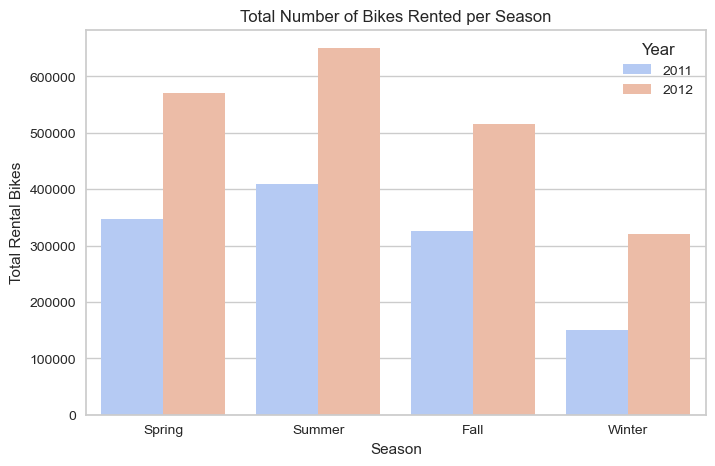

In [16]:
season_labels = {1: "Winter", 2: "Spring", 3: "Summer", 4: "Fall"}

season_counts = ds.groupby(["season", "yr"], observed=False)["cnt"].sum().reset_index()

season_counts["season"] = season_counts["season"].map(season_labels)

season_order = ["Spring", "Summer", "Fall", "Winter"]
season_counts["season"] = pd.Categorical(season_counts["season"], categories=season_order, ordered=True)

season_counts["yr"] = season_counts["yr"].map({0: 2011, 1: 2012})

plt.figure(figsize=(8, 5))
sns.barplot(x="season", y="cnt", hue="yr", data=season_counts, palette="coolwarm")

plt.title("Total Number of Bikes Rented per Season")
plt.xlabel("Season")
plt.ylabel("Total Rental Bikes")
plt.legend(title="Year")

plt.show()

Analizing numerical variables...

array([[<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'hum'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'cnt'}>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object)

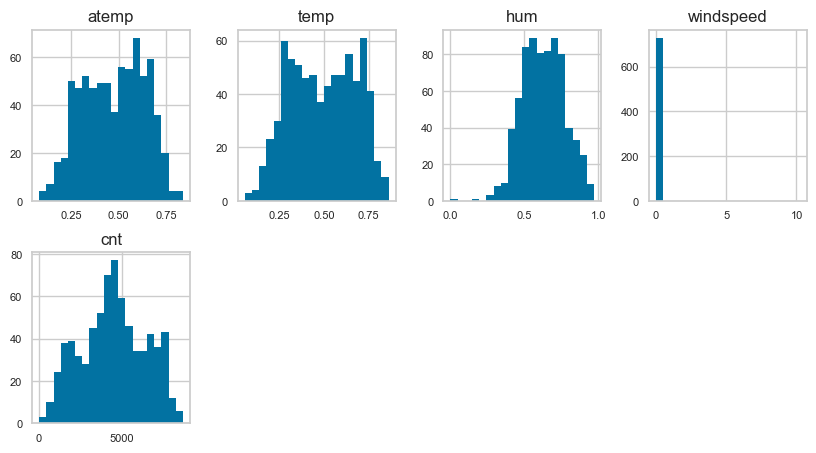

In [17]:
selected_columns = ["atemp", "temp", "hum", "windspeed", "cnt"]

numerical = ds.select_dtypes(include=[np.number]).columns.tolist()
filtered_columns = [col for col in selected_columns if col in numerical]

ds[filtered_columns].hist(bins=20, figsize=(10, 8), layout=(3, 4), xlabelsize=8, ylabelsize=8)


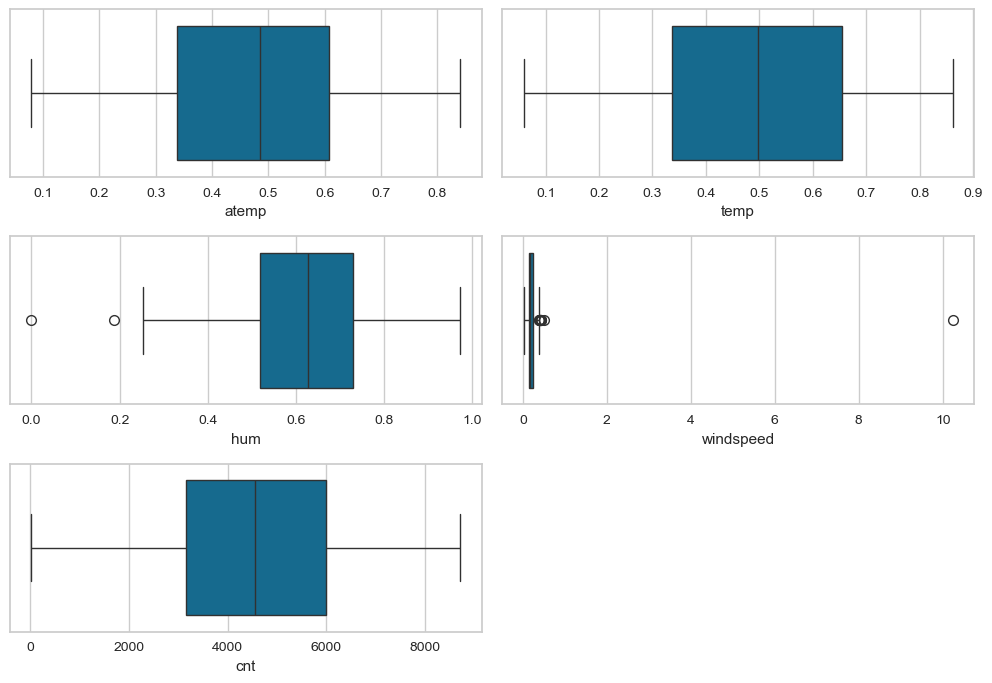

In [18]:
num_vars = len(filtered_columns)
rows = (num_vars // 2) + (num_vars % 2) 

fig, ax = plt.subplots(rows, 2, figsize=(10, 7))  
ax = ax.flatten()  

for i, var in enumerate(filtered_columns):
    sns.boxplot(x=ds[var], ax=ax[i])

for j in range(i + 1, len(ax)):  
    ax[j].set_visible(False)

plt.tight_layout()  
plt.show()


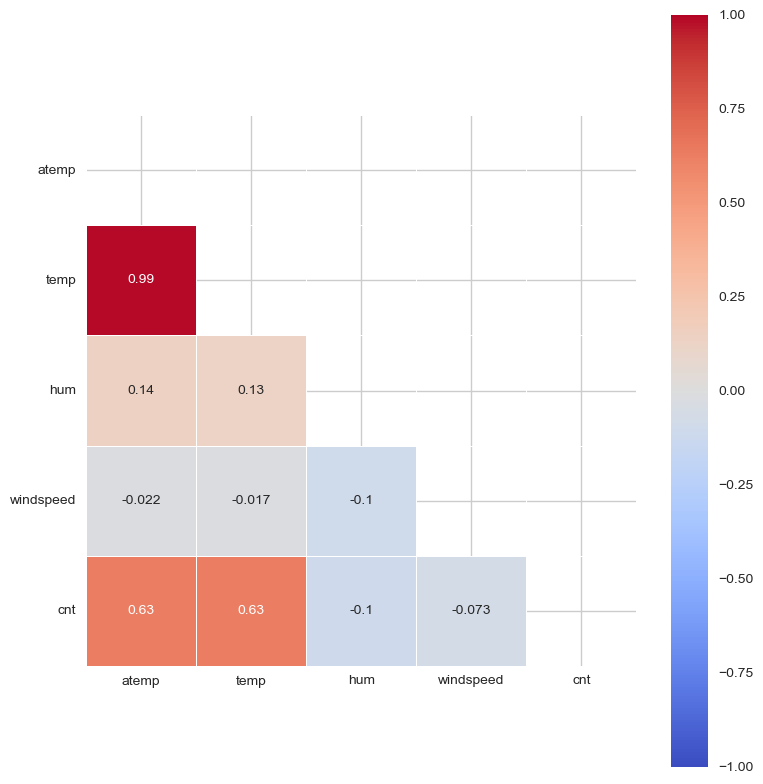

In [19]:
corr = ds[filtered_columns].corr()


mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(8, 8))
heatmap = sns.heatmap(corr,
                      mask=mask,
                      square=True,
                      linewidths=.5,
                      cmap='coolwarm',
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 10})

ax.set_yticklabels(corr.columns, rotation=0)
ax.set_xticklabels(corr.columns, rotation=0)


sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

plt.tight_layout()  
plt.show()

`atemp` is extremely highly correlated to `temp`, so we decide to only use `atemp`

## Data Preparation

In [20]:
X = ds.copy(deep=True)

In [21]:
X.drop(X[X.windspeed > 1].index, inplace=True)
#remove outliers in the windspeed column

In [22]:
binsInterval = [0.07907, 0.337891, 0.487364, 0.608289, 0.840896	] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0.07907, 0.337891]', '(0.337892,  0.487364]',  '(0.487365, 0.608289]', '(0.608290, 0.840896]']
X['atemp_binned'] = pd.cut(X['atemp'], bins = binsInterval, labels=intervalLabels)

In [23]:
binsInterval = [0.0, 0.519792, 0.62625, 0.730104, 0.9725] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0.0, 0.519792]', '(0.519793, 0.62625]', '(0.626251, 0.730104]', '(0.730105, 0.9725]']
X['hum_binned'] = pd.cut(X['hum'], bins=binsInterval, labels=intervalLabels)


In [24]:
binsInterval= [0.022392, 0.13495, 0.180975, 0.233376, 10.234234] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0.022392, 0.13495]', '(0.134951, 0.180975]', '(0.180976, 0.233376]', '(0.233377, 10.234234]']
X['windspeed_binned'] = pd.cut(X['windspeed'], bins=binsInterval, labels=intervalLabels)

Convert to binary:

In [25]:
cols = cols = ['atemp_binned', 'hum_binned', 'windspeed_binned','season','weathersit']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

Remove outliers:

In [26]:
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

cols = ['hum','windspeed', 'cnt']
X = removeOutliers(X, colList=cols , lowPercentile=0.01, highPercentile=0.99, verbose=True)

           hum  windspeed      cnt
0.01  0.312067   0.052967   689.16
0.99  0.928000   0.408690  8171.32


In [27]:
X.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
instant,684.0,NaN,NaN,NaN,368.236842,1.0,183.75,369.5,551.25,731.0,211.154775
dteday,684,NaN,NaN,NaN,2012-01-03 05:41:03.157894656,2011-01-01 00:00:00,2011-07-02 18:00:00,2012-01-04 12:00:00,2012-07-04 06:00:00,2012-12-31 00:00:00,NaN
season_1.0,684.0,NaN,NaN,NaN,0.239766,0.0,0.0,0.0,0.0,1.0,0.427253
season_2.0,684.0,NaN,NaN,NaN,0.25731,0.0,0.0,0.0,1.0,1.0,0.437472
season_3.0,684.0,NaN,NaN,NaN,0.26462,0.0,0.0,0.0,1.0,1.0,0.441453
season_4.0,684.0,NaN,NaN,NaN,0.238304,0.0,0.0,0.0,0.0,1.0,0.426358
yr,684.0,2.0,1.0,346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mnth,684.0,NaN,NaN,NaN,6.533626,1.0,4.0,7.0,9.0,12.0,3.422051
holiday,684.0,2.0,0.0,665.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,684.0,7.0,2.0,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

Target is the number of bicycles that we need for the next day, in our case is count.

In [28]:
y = X['cnt']

We do not use `casual` and `registered` since the model would only use these two variables. It would not perform as desired.

In [29]:
cols = ['temp', 'cnt','dteday','casual','registered', 'instant', 'atemp','hum','windspeed', 'schoolday']
X = X.drop(columns=cols)

Apply min max to normalize the data:

In [30]:
X = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(X.values), columns=X.columns,index=X.index)

Split the data for testing and training:

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size = 0.25, random_state = 2025)

## Linear Regression

Linear regression was adopted as the initial model due to its simplicity, computational efficiency, and ease of interpretation. This algorithm enables the identification of the underlying structure within the data, serving as a baseline to assess whether more complex models are required. Furthermore, it provides a transparent view of the contribution of each predictor variable to the number of rented bicycles, thereby facilitating analysis and comparison with more advanced approaches.

In [32]:
lr_regr = linear_model.LinearRegression()

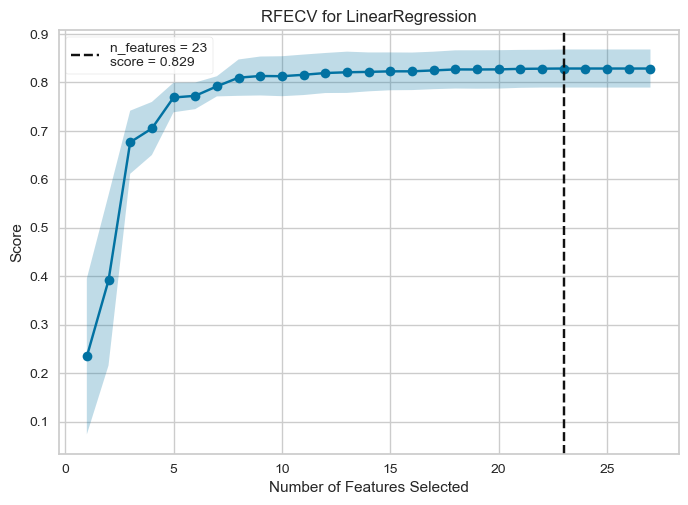

<Axes: title={'center': 'RFECV for LinearRegression'}, xlabel='Number of Features Selected', ylabel='Score'>

In [33]:
vis = RFECV(lr_regr, cv=5, scoring='r2')
vis.fit(X_train, y_train)
vis.show()

In [34]:
X.columns[vis.support_]

Index(['season_1.0', 'season_2.0', 'season_3.0', 'season_4.0', 'yr', 'mnth',
       'holiday', 'weekday', 'workingday', 'weathersit_2.0', 'weathersit_1.0',
       'weathersit_3.0', 'atemp_binned_(0.07907, 0.337891]',
       'atemp_binned_(0.337892,  0.487364]',
       'atemp_binned_(0.487365, 0.608289]',
       'atemp_binned_(0.608290, 0.840896]', 'atemp_binned_nan',
       'hum_binned_(0.0, 0.519792]', 'hum_binned_(0.519793, 0.62625]',
       'hum_binned_(0.730105, 0.9725]', 'windspeed_binned_(0.022392, 0.13495]',
       'windspeed_binned_(0.180976, 0.233376]',
       'windspeed_binned_(0.233377, 10.234234]'],
      dtype='object')

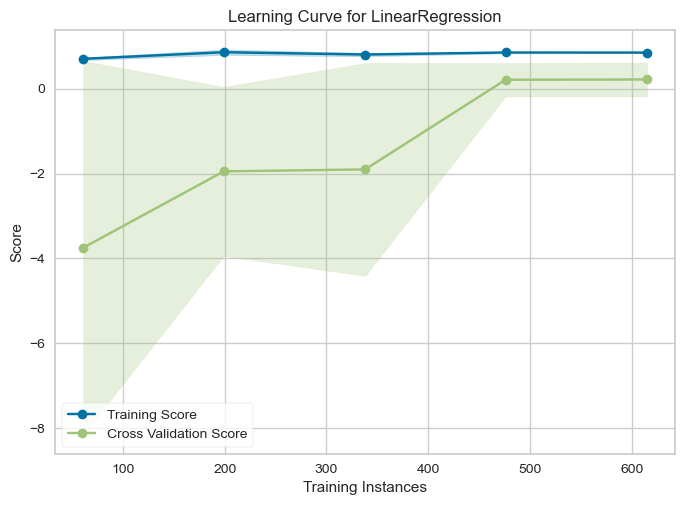

<Axes: title={'center': 'Learning Curve for LinearRegression'}, xlabel='Training Instances', ylabel='Score'>

In [35]:
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=lr_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X, y)
visualizer.show()     

In [36]:
# Create and train the model
lr_regr.fit(X_train, y_train)

LinearRegression()

In [37]:
# Print the Intercept
print('Intercept:',lr_regr.intercept_, '\n')

# Print Coefficients by descending "importance"
formattedList = [format(float(i),'.6f') for i in lr_regr.coef_]
formattedList2 = [format(abs(float(i)),'.6f') for i in lr_regr.coef_]
data_tuples = list(zip(X.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df['AbsCoefficient']=coeff_df['AbsCoefficient'].astype(float)
coeff_df.sort_values('AbsCoefficient', axis=0, inplace=True, ascending=False)
coeff_df

Intercept: 2267.674474655191 



,Feature,Coefficient,AbsCoefficient
4,yr,2039.249341,2039.249341
16,atemp_binned_nan,-1532.984339,1532.984339
14,"atemp_binned_(0.487365, 0.608289]",1259.359810,1259.359810
11,weathersit_3.0,-1150.542255,1150.542255
0,season_1.0,-1058.019885,1058.019885
15,"atemp_binned_(0.608290, 0.840896]",1013.649258,1013.649258
12,"atemp_binned_(0.07907, 0.337891]",-847.964162,847.964162
10,weathersit_1.0,828.104235,828.104235
3,season_4.0,604.233191,604.233191
7,weekday,403.274839,403.274839


In [38]:
# predict y for X_train and X_test
y_pred_train = lr_regr.predict(X_train) 
y_pred_test = lr_regr.predict(X_test) 

In [39]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [40]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,538.922779,527.927648
1,RMSE,721.929999,711.613398
2,R^2,0.849544,0.856909
3,MAPE (%),0.157344,0.172739
4,MAX Error,3124.377122,3250.806779


C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


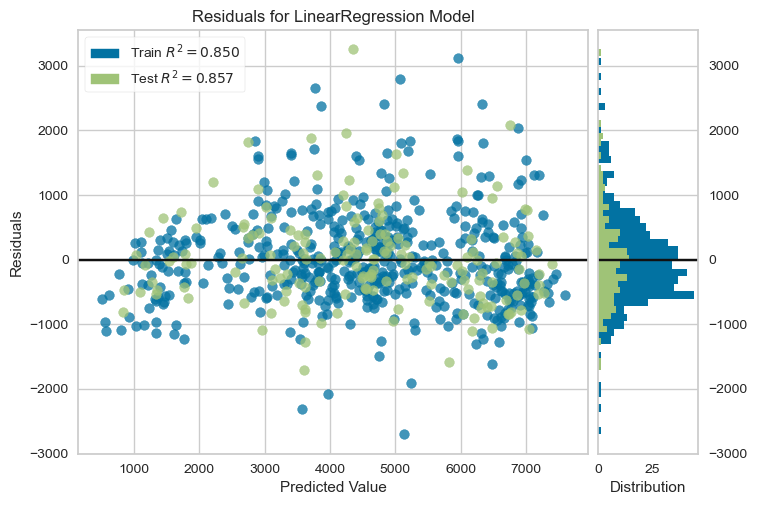

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [41]:
# Visualize the residuals
residuals_vis = ResidualsPlot(lr_regr)
residuals_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X_test, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


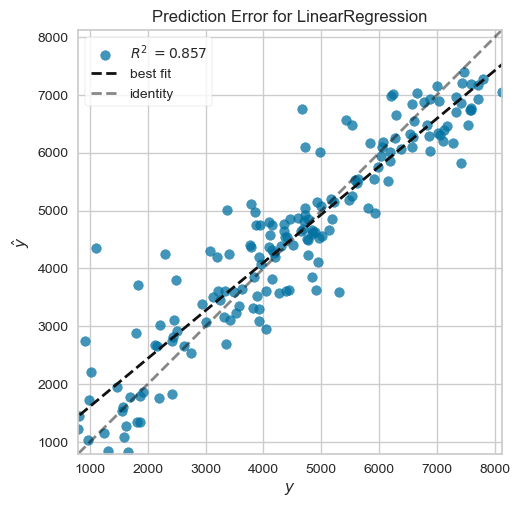

<Axes: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [42]:
# Visualize the prediction error
predError_vis = PredictionError(lr_regr)
predError_vis.fit(X_train, y_train)  # Fit the training data to the visualizer
predError_vis.score(X_test, y_test)  # Evaluate the model on the test data
predError_vis.show() 

## Decision Trees


The decision trees was selected for its ability to model non-linear relationships between variables, as well as its ability to handle outliers and missing values effectively. In addition, it is capable of capturing complex interactions between variables, offering a hierarchical structure that reflects the relative importance of each attribute in predicting the number of rented bicycles. Although it is prone to overfitting, it remains an effective tool for uncovering deeper patterns in the data and deriving rule-based interpretations.

A new copy was created since on this one we do not normalize the data.

In [43]:
X1 = ds.copy(deep=True)

In [44]:
X1.drop(X1[X1.windspeed > 1].index, inplace=True)

In [45]:
binsInterval = [0.07907, 0.337891, 0.487364, 0.608289, 0.840896	] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0.07907, 0.337891]', '(0.337892,  0.487364]',  '(0.487365, 0.608289]', '(0.608290, 0.840896]']
X1['atemp_binned'] = pd.cut(X1['atemp'], bins = binsInterval, labels=intervalLabels)

In [46]:
binsInterval = [0.0, 0.519792, 0.62625, 0.730104, 0.9725] # Create bins interval based on distribution/quartiles
intervalLabels = ['(0.0, 0.519792]', '(0.519793, 0.62625]', '(0.626251, 0.730104]', '(0.730105, 0.9725]']
X1['hum_binned'] = pd.cut(X1['hum'], bins=binsInterval, labels=intervalLabels)


In [47]:
binsInterval= [0.022392, 0.13495, 0.180975, 0.233376, 10.234234]
intervalLabels = ['(0.022392, 0.13495]', '(0.134951, 0.180975]', '(0.180976, 0.233376]', '(0.233377, 10.234234]']
X1['windspeed_binned'] = pd.cut(X1['windspeed'], bins=binsInterval, labels=intervalLabels)

In [48]:
cols = cols = ['atemp_binned', 'hum_binned', 'windspeed_binned','season','weathersit']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X1 = ce_one_hot.fit_transform(X1)

In [49]:
# Function to find outliers on columns based on percentile
def removeOutliers(df, colList, lowPercentile=0.05, highPercentile=0.95, verbose=False):
    quant_df = df[colList].quantile([lowPercentile, highPercentile])
    if verbose:
        print(quant_df)
    for name in list(df[colList].columns):
        df = df[(df[name] >= quant_df.loc[lowPercentile, name]) & (df[name] <= quant_df.loc[highPercentile, name])]
    return df

# Find and remove outliers
cols = ['hum', 'windspeed', 'cnt']
X1 = removeOutliers(X1, colList=cols , lowPercentile=0.02, highPercentile=0.98, verbose=True)  

           hum  windspeed      cnt
0.02  0.357433   0.061921   971.32
0.98  0.908366   0.374926  7886.28


We discarted more outliers because this model was affected by them.

In [50]:
y = X1['cnt']

In [51]:
cols = ['temp', 'cnt','dteday','casual','registered', 'instant', 'atemp','hum','windspeed','schoolday']
X1 = X1.drop(columns=cols)

In [52]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, train_size = 0.75, test_size = 0.25, random_state = 2025)

In [53]:

from sklearn import tree
tree_regr = tree.DecisionTreeRegressor(random_state=123, max_depth=5, min_samples_leaf=8, max_leaf_nodes=30, min_samples_split=2)

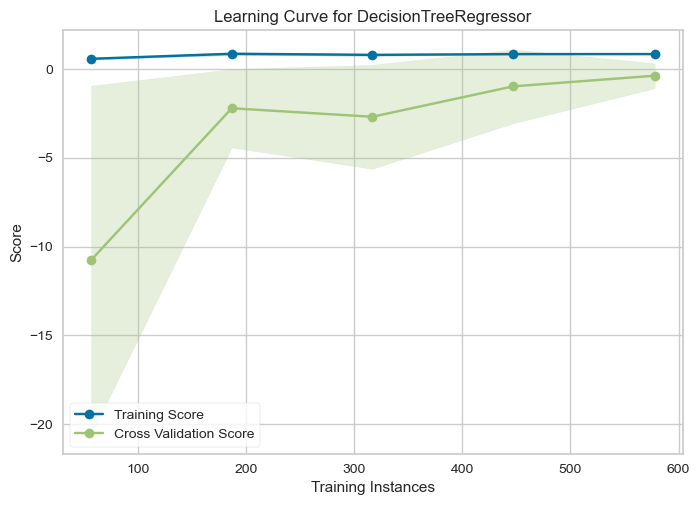

<Axes: title={'center': 'Learning Curve for DecisionTreeRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [54]:

cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=tree_regr, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X1, y)
visualizer.show()     

In [55]:
# Create and train the model
tree_regr.fit(X1_train.values, y_train)

DecisionTreeRegressor(max_depth=5, max_leaf_nodes=30, min_samples_leaf=8,
                      random_state=123)

In [56]:
# Explore feature importance (Gini importance - normalized)
formattedList = [float(format(member,'.6f')) for member in tree_regr.feature_importances_]
formattedList2 = [abs(float(format(member,'.6f'))) for member in tree_regr.feature_importances_]
data_tuples = list(zip(X1.columns,formattedList,formattedList2))
coeff_df = pd.DataFrame(data=data_tuples, columns=['Feature','Coefficient','AbsCoefficient'])
coeff_df.reset_index(drop=True, inplace=True)
coeff_df.sort_values(by=['AbsCoefficient'], inplace=True, ascending=False)
coeff_df

,Feature,Coefficient,AbsCoefficient
12,"atemp_binned_(0.07907, 0.337891]",0.401720,0.401720
4,yr,0.332067,0.332067
13,"atemp_binned_(0.337892, 0.487364]",0.120723,0.120723
3,season_4.0,0.048269,0.048269
10,weathersit_1.0,0.027013,0.027013
5,mnth,0.019627,0.019627
20,"hum_binned_(0.730105, 0.9725]",0.018455,0.018455
0,season_1.0,0.017774,0.017774
7,weekday,0.009253,0.009253
24,"windspeed_binned_(0.180976, 0.233376]",0.005101,0.005101


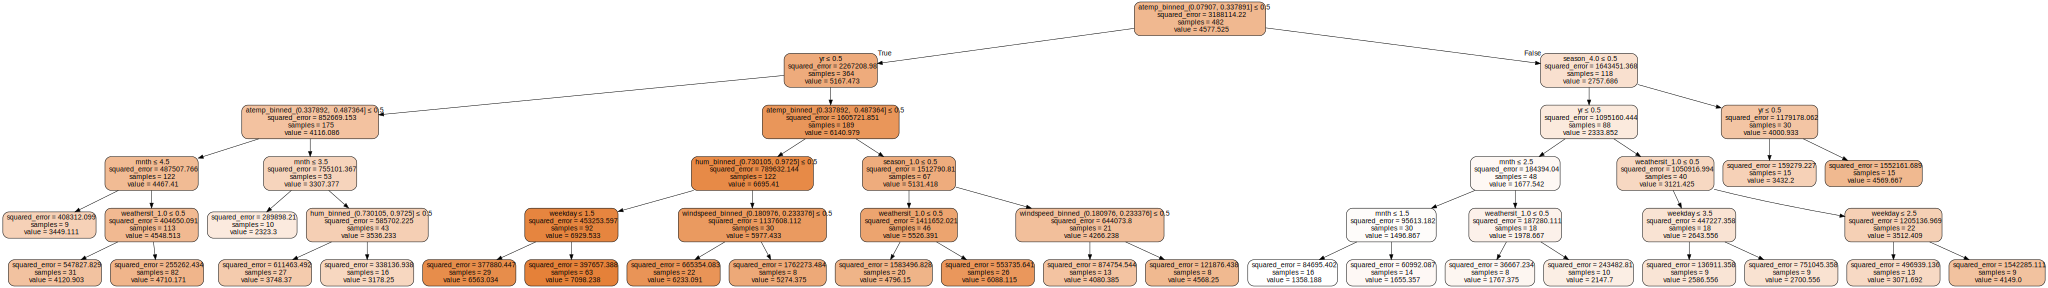

In [57]:
# Plot the tree


dot_data = tree.export_graphviz(tree_regr, out_file=None, 
                      feature_names=list(X1_train.columns),  
                      filled=True, rounded=True,  
                      special_characters=True)   
graph = graphviz.Source(dot_data)  
graph 

In [58]:
# predict y for X_train and X_test
y_pred_train = tree_regr.predict(X1_train.values) 
y_pred_test = tree_regr.predict(X1_test.values) 

In [59]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [60]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,520.564203,615.424043
1,RMSE,718.039154,787.310268
2,R^2,0.838281,0.826140
3,MAPE (%),0.149366,0.172918
4,MAX Error,3769.150000,2468.111111


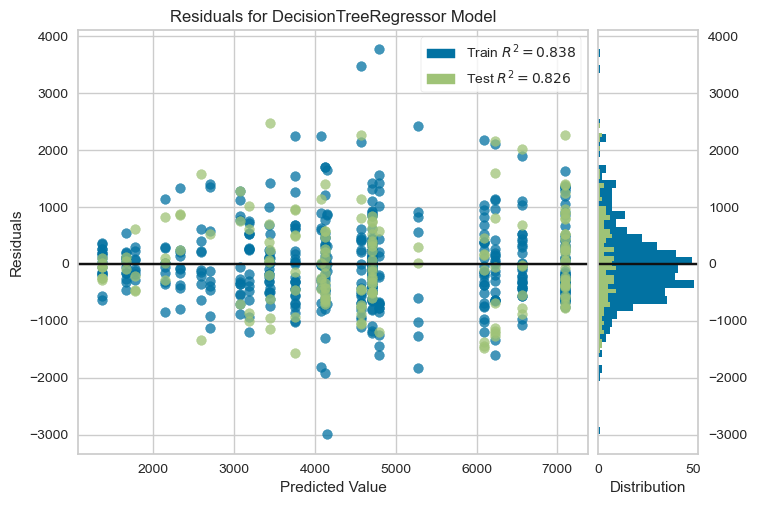

<Axes: title={'center': 'Residuals for DecisionTreeRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [61]:
# Visualize the residuals
residuals_vis = ResidualsPlot(tree_regr)
residuals_vis.fit(X1_train.values, y_train)  # Fit the training data to the visualizer
residuals_vis.score(X1_test.values, y_test)  # Evaluate the model on the test data
residuals_vis.show() 

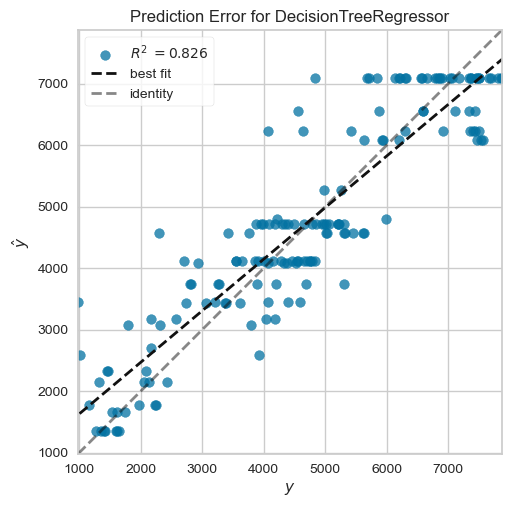

<Axes: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [62]:
# Visualize the prediction error
predError_vis = PredictionError(tree_regr)
predError_vis.fit(X1_train.values, y_train)  # Fit the training data to the visualizer
predError_vis.score(X1_test.values, y_test)  # Evaluate the model on the test data
predError_vis.show() 


## Neural Networks

In this project, our goal was to predict, in the prior day at 3pm, the total number of bikes that would be rented daily, a regression problem with both time-based and environmental (weather) predictors. We considered multiple modeling approaches based on the reference notebooks provided by the professor, all using variations of a Neural Network (MLPRegressor). Here’s why we selected this specific version:
Among the options, MLPRegressor with GridSearchCV allowed us to systematically test multiple hidden layer sizes and configurations, while finding the optimal balance between model complexity and generalization. On another hand we were able to minimize overfitting through controlled parameter tuning (e.g., alpha, activation, max_iter). 

This made it more flexible than using a default neural net configuration or even RandomizedSearch, which may miss good combinations.

We also attempted to implement Optuna, but the trials repeatedly failed to converge or returned -inf values. Also many combinations led to unstable models and the visualization and interpretability were harder compared to GridSearchCV.

In [63]:
# Create the Target
y = ds['cnt']  

In [64]:
# Normalize training data
from sklearn.preprocessing import MinMaxScaler
X = ds[['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
        'schoolday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]

scaler = MinMaxScaler(feature_range=(0, 1))

# MinMax scaler returns an array, so the dataframe must be recreated
X_scaled = pd.DataFrame(scaler.fit_transform(X.values), columns=X.columns,index=X.index)

In [65]:
# Drop rows with any missing values
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy.drop(columns='cnt')
y = Xy['cnt']

In [66]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, random_state=123)

1st Attempt

In [67]:
""" # Execute Grid Search to hyper tune parameters
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define grid of parameters to search
grid_param = [{
    'hidden_layer_sizes': [3, 4, 5, 6, 7, 8],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.002, 0.05],
    'batch_size': ['auto'],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.002],
    'max_iter': [100, 300, 500, 700, 900],
    'random_state': [123]
}]


reg = MLPRegressor()
grid = GridSearchCV(reg, grid_param, cv=5)
grid.fit(X_train.values, y_train)

print("best parameters:", grid.best_params_) """

' # Execute Grid Search to hyper tune parameters\nfrom sklearn.neural_network import MLPRegressor\nfrom sklearn.model_selection import GridSearchCV\n\n# Define grid of parameters to search\ngrid_param = [{\n    \'hidden_layer_sizes\': [3, 4, 5, 6, 7, 8],\n    \'activation\': [\'tanh\', \'relu\'],\n    \'solver\': [\'lbfgs\', \'adam\'],\n    \'alpha\': [0.0001, 0.002, 0.05],\n    \'batch_size\': [\'auto\'],\n    \'learning_rate\': [\'constant\'],\n    \'learning_rate_init\': [0.001, 0.002],\n    \'max_iter\': [100, 300, 500, 700, 900],\n    \'random_state\': [123]\n}]\n\n\nreg = MLPRegressor()\ngrid = GridSearchCV(reg, grid_param, cv=5)\ngrid.fit(X_train.values, y_train)\n\nprint("best parameters:", grid.best_params_) '

2nd Attempt

In [68]:
# Execute Grid Search to hyper tune parameters
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

# Define grid of parameters to search
grid_param = [{
    'hidden_layer_sizes': [8, 16, 32, 64],
    'activation': ['tanh', 'relu'],
    'solver': ['lbfgs', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5],
    'batch_size': ['auto'],
    'learning_rate': ['constant'],
    'learning_rate_init': [0.001, 0.002],
    'max_iter': [100, 300, 500, 700, 900],
    'random_state': [123]
}]


reg = MLPRegressor()
grid = GridSearchCV(reg, grid_param, cv=5)
grid.fit(X_train.values, y_train)

print("best parameters:", grid.best_params_)

C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_mult

best parameters: {'activation': 'relu', 'alpha': 0.01, 'batch_size': 'auto', 'hidden_layer_sizes': 64, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 900, 'random_state': 123, 'solver': 'lbfgs'}


C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


The first attempt was done with hyperparameters values given by the professor. After checking the results, in order to improve the model we changed the following hyperparameters:
* hidden_layer_sizes: we increased the number of neurons to capture more complex patterns and reduce underfitting.
* alpha: we increased the range to prevent overfitting by not memorizing the data, therefore learning more simple generalizable patterns.

As a result, the model is now more balanced, effectively capturing patterns without overfitting or underfitting.
Even though it took a few more minutes to run, the results were noticeably better.

In [69]:
# Create the model
estimator = MLPRegressor(**grid.best_params_)

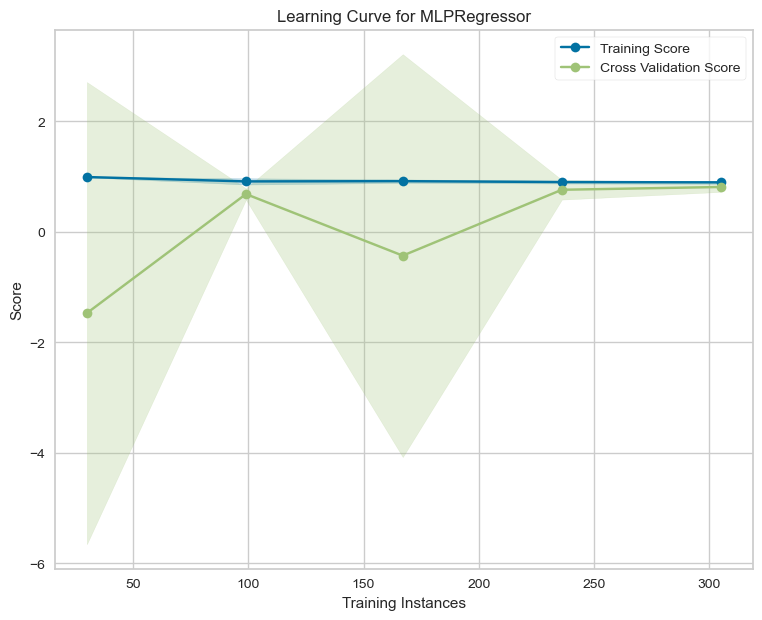

<Axes: title={'center': 'Learning Curve for MLPRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [70]:
# Plot the learning curve
fig, ax = plt.subplots(figsize=(9, 7))
cv = 10
sizes = np.linspace(0.1, 1.0, 5)
visualizer = LearningCurve(estimator=estimator, cv=cv, scoring='r2', train_sizes=sizes, n_jobs=4, random_state=123)
visualizer.fit(X_train.values, y_train)
visualizer.show(ax=ax)

In [71]:
# Create and train the model
estimator.fit(X_train.values, y_train)

C:\Users\Laura.LAPTOP-IJA5A916\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPRegressor(alpha=0.01, hidden_layer_sizes=64, max_iter=900, random_state=123,
             solver='lbfgs')

**Evaluation** 

In [72]:
# predict y for X_train and X_test
y_pred_train = estimator.predict(X_train.values) 
y_pred_test = estimator.predict(X_test.values) 

In [73]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest,set1='Train', set2='Test'):
  measures_list = ['MAE','RMSE', 'R^2','MAPE (%)','MAX Error']
  train_results = [metricsObj.mean_absolute_error(yTrain, yPredTrain),
                np.sqrt(metricsObj.mean_squared_error(yTrain, yPredTrain)),
                metricsObj.r2_score(yTrain, yPredTrain),
                metricsObj.mean_absolute_percentage_error(yTrain, yPredTrain),
                metricsObj.max_error(yTrain, yPredTrain)]
  test_results = [metricsObj.mean_absolute_error(yTest, yPredTest),
                np.sqrt(metricsObj.mean_squared_error(yTest, yPredTest)),
                metricsObj.r2_score(yTest, yPredTest),
                  metricsObj.mean_absolute_percentage_error(yTest, yPredTest),
                metricsObj.max_error(yTest, yPredTest)]
  resultsDF = pd.DataFrame({'Measure': measures_list, set1: train_results, set2:test_results})
  return(resultsDF)

In [74]:
# Show performance results
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,MAE,477.931730,482.160099
1,RMSE,682.809108,687.971743
2,R^2,0.891778,0.897294
3,MAPE (%),0.137014,0.123398
4,MAX Error,2797.932307,2187.539892


In [75]:
# Visualize predictions vs target values 
temp = y_test.to_frame()
temp['Prediction'] = y_pred_test
temp['Residual'] = y_test - temp.Prediction
temp

,cnt,Prediction,Residual
66,2133,2358.119408,-225.119408
102,2162,2292.142941,-130.142941
51,1107,1211.145817,-104.145817
421,3389,3264.079514,124.920486
425,4990,5564.288012,-574.288012
...,...,...,...
99,2895,2934.673533,-39.673533
395,4509,4443.168974,65.831026
638,8555,8575.759806,-20.759806
470,7132,6886.968163,245.031837


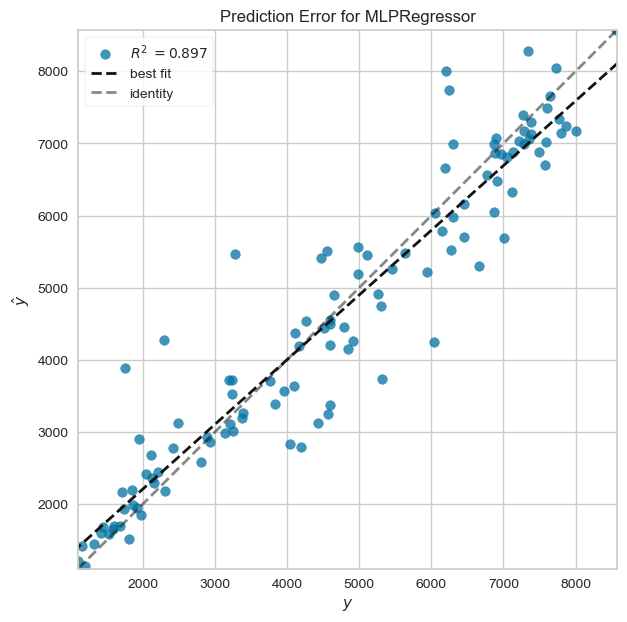

<Axes: title={'center': 'Prediction Error for MLPRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [76]:
# Visualize the prediction error
fig, ax = plt.subplots(figsize=(9, 7))
predError_vis = PredictionError(estimator)
predError_vis.fit(X_train.values, y_train) 
predError_vis.score(X_test.values, y_test)  
predError_vis.show(ax=ax)

### Final remarks

In this project, we built and tested several regression models to help the client, a bike rental company, predict the total number of bikes that will be rented on the following day. The goal was to generate these predictions by 15:00 each day, so the company can use them to proactively allocate staff and define their marketing budget, specially for social media, which is their main advertising channel.

We tested three types of models: Linear Regression, Decision Tree Regressor and Neural Network (MLPRegressor), optimized using GridSearchCV. 

Each model was evaluated using standard regression metrics: MAE, RMSE, R², MAPE, and Max Error.
While all models provided valuable insights, the neural network consistently delivered the best overall performance, with the highest R² score and lowest prediction errors on the test set. It was especially effective at capturing the complex relationships between variables like weather, the days on the calendar, and daily rental behavior.

Although it required more training time and hyperparameter tuning, the neural network’s predictive accuracy makes it the most suitable model for supporting the client’s day-to-day operational decisions. Therefore, we recommend it as the final solution for forecasting bike rentals and guiding both staffing and marketing efforts in a proactive, data-driven way.

We also thought while doing the project that in future iterations, the model could be further improved by incorporating real-time data such as hourly weather forecasts or events in the city that might impact demand. Additionally, we could test ensemble other methods to explore whether more advanced models could push prediction accuracy even further. For now, the neural network model offers a solid and practical solution aligned with the client's business needs.